# Get Seismograms
### - Read seismic data from the IRIS-DMC
### - Deconvolve instrument response
### - Filter & save

In [1]:
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
from scipy import fftpack as spfft # for computing spectra
from datetime import datetime, timedelta
import calendar
import pandas as pd
% matplotlib inline
# Set plot fontsize
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
########## 1-get_event_waveforms ##########
webservice = "IRIS" # Do not edit
sr_new = 1; # [hz] sample rate to resample to
tlag_start_sec = 1*60*60 # Number of seconds to shift start time 
trlen = 7*60*60 # Length of traces (sec)
comps = ["BHZ"] # Components to download
datadir = '../data/'

#Bandpass filtered
# fmin = 1/150
# fmax = 1/10
################################################
################################################



################ M9.1 ################
# tstart = "2011-03-11T05:46:24" # M9.1 Tohoku
# eqlat = 38.297
# eqlon = 142.373
# eqstr = "M9.1"

# # STATION LOCAL TO JAPAN (~3.75 deg)
# network = "IU"
# station = "MAJO"
# stalat = 36.54567
# stalon = 138.20406

# # STATION IN MO (~87.26 deg)
# network = "TA"
# station = "P39A"
# stalat = 39.4877
# stalon = -92.7549

# # STATION IN SOUTH AMERICA (~160.91 deg)
# network = "IU"
# station = "TRQA"
# stalat = -38.0568
# stalon = -61.9787

# # STATION IN SOUTH AMERICA (~150 deg)
# network = "IU"
# station = "LCO"
# stalat = -29.011
# stalon = -70.7005

################ M7.3 foreshock ################
# tstart = "2011-03-09 02:45:20" # M7.3 Tohoku foreshock
# eqlat = 38.435
# eqlon = 142.842
# eqstr = "M7.3"

# STATION LOCAL TO JAPAN (~3.75 deg)
# network = "IU"
# station = "MAJO"
# stalat = 36.54567
# stalon = 138.20406

# # STATION IN MO (~87.26 deg)
# network = "TA"
# station = "P39A"
# stalat = 39.4877
# stalon = -92.7549

# # STATION IN SOUTH AMERICA (~160.91 deg)
# network = "IU"
# station = "TRQA"
# stalat = -38.0568
# stalon = -61.9787

# # STATION IN SOUTH AMERICA (~150 degrees)
# network = "IU"
# station = "LCO"
# stalat = -29.011
# stalon = -70.7005

################# Background Noise ##################
tstart = "2011-03-01T05:46:24" # M9.1 Tohoku
eqlat = 38.297 # dummy
eqlon = 142.373 # dummy
eqstr = "Noise"

# STATION IN MO (~87.26 deg)
network = "TA"
station = "P39A"
stalat = 39.4877
stalon = -92.7549


In [3]:
# Calculate distance between event and station
dist = obspy.geodetics.locations2degrees(eqlat,eqlon,stalat,stalon)
dist_km = obspy.geodetics.degrees2kilometers(dist)
print(dist)
print(dist_km)

87.2601639583
9702.88753033


In [4]:
# LOAD CLIENT
client = Client(webservice)
print(client)


FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.9), 'event' (v1.1.13), 'station' (v1.1.45), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


/Users/russell/anaconda/lib/python3.5/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: 

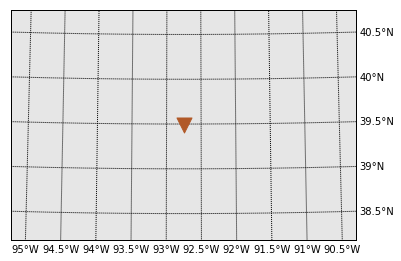

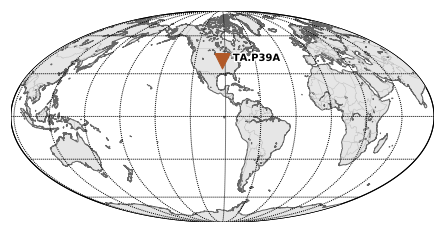

In [5]:
# LOAD STATIONS
t1 = UTCDateTime(tstart) - tlag_start_sec
inventory = client.get_stations(network=network, station=station, channel=comps[0], starttime=t1, endtime=t1+trlen)
inventory.plot(projection="local",label=False)
fig = inventory.plot(method="basemap", show=True) 

In [6]:
st = client.get_waveforms(network=network, station=station, location="*", channel=",".join(comps), starttime=t1, endtime=t1+trlen, attach_response=True)
st[0]
sr = st[0].stats.sampling_rate
# Remove instrument response
st.remove_response(output="DISP", zero_mean=True, taper=True, taper_fraction=0.05, pre_filt=[0.001, 0.005, sr/3, sr/2], water_level=60)

# resample to specified sample rate
if sr != sr_new:
    st.resample(sampling_rate=sr_new)
    sr = st[0].stats.sampling_rate

st

/Users/russell/anaconda/lib/python3.5/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


1 Trace(s) in Stream:
TA.P39A..BHZ | 2011-03-01T04:46:24.024998Z - 2011-03-01T11:46:23.024998Z | 1.0 Hz, 25200 samples

In [7]:
sr

1.0

/Users/russell/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10


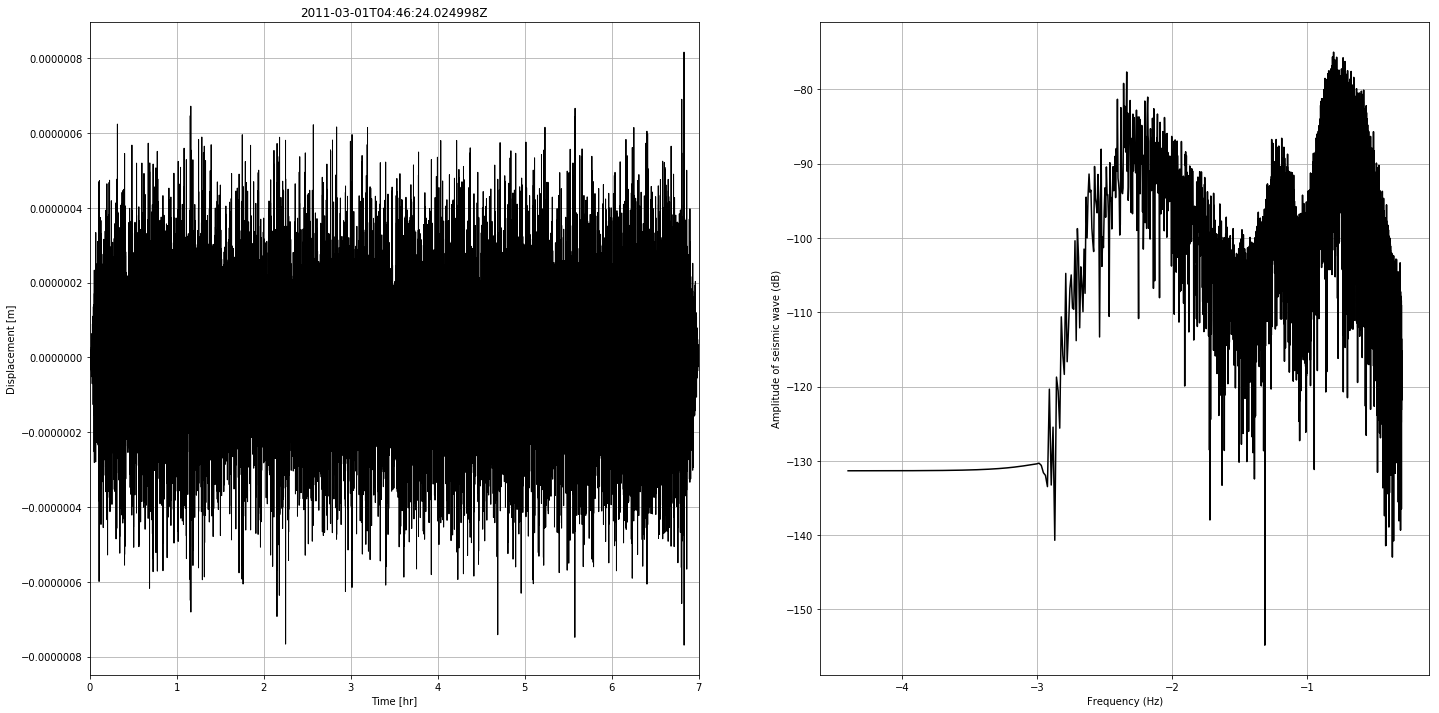

In [8]:
# Filter
# st_filt = st.copy()
# st_filt.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# plot
# st_filt.plot(color='black', tick_format='%I:%M %p')

# plot new
icomp = 0; # 2=BHZ
data = st[icomp].data
# data = st_filt[icomp].data
npts = st[icomp].stats.npts
samprate = st[icomp].stats.sampling_rate
t = np.arange(0, npts / samprate, samprate)

plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t/60/60, data, color='black',linewidth=1)
plt.title(st[icomp].stats.starttime)
plt.ylabel('Displacement [m]')
plt.xlabel('Time [hr]')
plt.xlim(t.min()/60/60,t.max()/60/60)
plt.grid()


plt.subplot(1,2,2)
Nfft = len(data)
f = np.arange(0,samprate/2,samprate/Nfft)
S = spfft.fft(data,Nfft); S = S[:int(Nfft/2)]
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()
plt.axis()

plt.show()
# fig.savefig('test.pdf', transparent=True)

time = [datetime.fromtimestamp(st[0].times('timestamp')[v]) for v in range(len(st[0].times()))]

# To dataframe
df = pd.DataFrame({'time':time,'t':t,'data':data}, index = time)
## Save trace to text file
fname = station+"_"+eqstr+"_"+comps[0]+".csv"
df.to_csv(datadir+fname, index=False)
